# Miami Weather Kalshi Bot
### The purpose of this Notebook, is to create a model that is able to provide a probability that a temperature belongs in a certain temperature interval. This is suppose to mimic the intervals that can be selected on Kalshi for the highest temperature in Miami. Additional testing with Kelly Criterion is also added at the end to find whether this model is profitable since we are unable to test on Kalshi itself.

#### **Note**: My dataset is coming from a CSV that was built using the KalshiDataCollection notebook. The data is from NOAA, which is the same data that Kalshi looks at when making decisions

#### **Model Created**:
- LSTM

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# !pip install tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [24]:
# added for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

Import data

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/miami_weather.csv")

# show head
print(df.head())
# show columns
print(df.columns)

         DATE  ADPT    ASLP    ASTP  AWBT  AWND  PRCP  RHAV  TAVG  TMAX  TMIN  \
0  2017-01-01  18.9  1021.3  1020.0  21.1   4.4   0.0   6.9  24.6  28.3  21.7   
1  2017-01-02  21.7  1020.7  1019.6  23.3   5.5   0.0   7.5  26.5  29.4  25.0   
2  2017-01-03  21.7  1016.3  1015.6  22.8   3.4  17.5   7.9  26.4  30.0  22.8   
3  2017-01-04  21.7  1012.9  1011.9  22.8   2.7   4.1   8.2  24.5  28.3  22.8   
4  2017-01-05  15.0  1013.5  1011.9  18.3   1.7   0.0   6.2  23.5  27.8  18.3   

   WSF2  WSF5                                          WT_VECTOR  
0   8.9  12.5  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  
1  10.3  13.9  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  
2   7.6  10.7  [0.  0.  0.1 0.  0.  0.  0.  0.1 0.  0.  0.  0...  
3   5.4   7.6  [0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0...  
4   5.4   8.5  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  
Index(['DATE', 'ADPT', 'ASLP', 'ASTP', 'AWBT', 'AWND', 'PRCP', 'RHAV', 'TAVG',
       'TMAX', 'TMIN', 'WSF2', '

In [5]:
# dropping the fastest 2,5 minute wind speed because
# I plan on only keeping the average wind speed
df = df.drop(columns=["WSF5", "WSF2"])

####Correlation HeatMap is showing a strong correlation for the max temperature and the following columns:
- Average dew point temperature (ADPT)
- Average wind gust (AWBT)

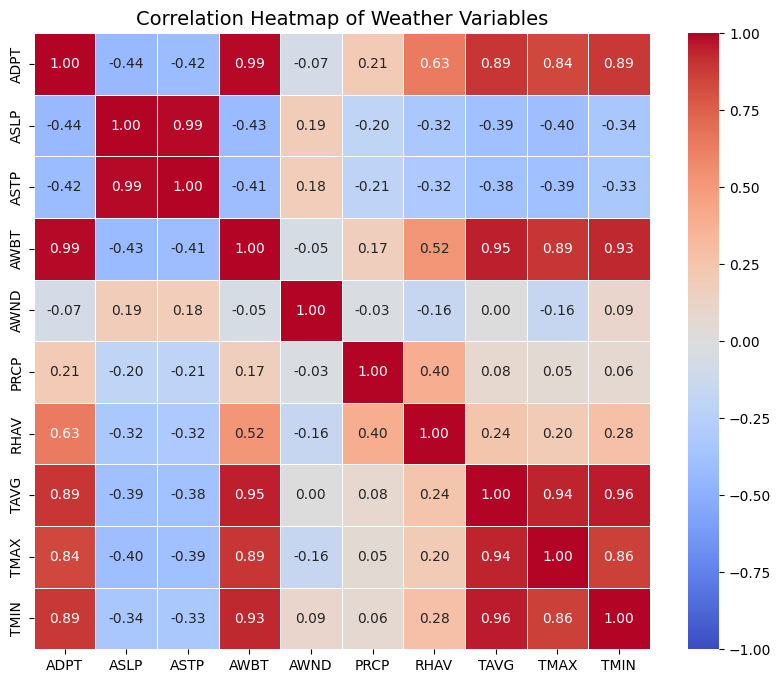

In [6]:
# correlcation matrix
corr = df.corr(numeric_only=True)

# set up the plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1,
    square=True,
    linewidths=0.5
)

plt.title("Correlation Heatmap of Weather Variables", fontsize=14)
plt.show()

#### Feature Engineering Notes:
- Temperature Max is very related to the season that Miami is in

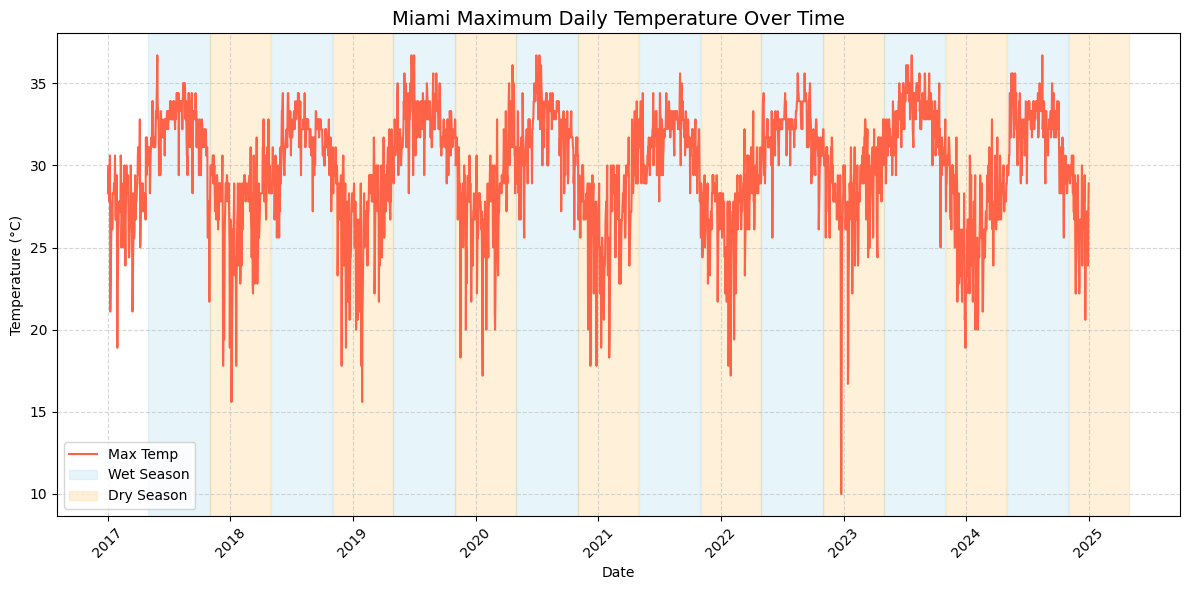

In [7]:
# convert to datetime for plotting
df['DATE'] = pd.to_datetime(df['DATE'])

plt.figure(figsize=(12, 6))
plt.plot(df['DATE'], df['TMAX'], color='tomato', label='TMAX')
plt.title("Miami Maximum Daily Temperature Over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.grid(True, linestyle='--', alpha=0.5)

# Note: I found the season for miami online
for year in df['DATE'].dt.year.unique():
    dry_start = pd.Timestamp(f"{year}-11-01")
    dry_end = pd.Timestamp(f"{year+1}-04-30")
    wet_start = pd.Timestamp(f"{year}-05-01")
    wet_end = pd.Timestamp(f"{year}-10-31")

    # shading to distinguish dry and wet seasons
    plt.axvspan(wet_start, wet_end, color='skyblue', alpha=0.2)
    plt.axvspan(dry_start, dry_end, color='orange', alpha=0.15)

# legend
plt.legend(["Max Temp", "Wet Season", "Dry Season"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Model: LSTM
### Training:
- Time Series Cross Validation

### Features:
- 3 Day Lag Features
- Season Features

In [8]:

def feature_setup(num_lag_features, num_intervals):
  """
  This function is in charge of setting up the lag features that
  include the previous days max temperature, and whether Miami is
  in a wet or dry season

  Returns:
  - features -> Lag Features
  - target_temp -> Highest actual temp
  - temps -> the list of max temperatures in the dataset
  """
  lag = num_lag_features
  num_intervals = num_intervals

  # max temperature lag features
  temps = df['TMAX'].values
  features = []
  for i in range(lag, len(temps)):
      features.append(temps[i-lag:i].reshape(lag, 1))
  features = np.array(features)

  # season feature
  season_feature = []
  for i in range(lag, len(df)):
      date = df['DATE'].iloc[i]
      if 5 <= date.month <= 10:
          season_feature.append([1])
      else:
          season_feature.append([0])
  season_feature = np.array(season_feature)

  # extend the season feature to the lag features
  season_feature_seq = np.repeat(season_feature.reshape(-1,1,1), lag, axis=1)

  # combine the season and max temperature lag features
  features = np.concatenate([features, season_feature_seq], axis=2)

  # save the actual max temperature of the day
  target_temp = temps[lag:]

  return features, target_temp, temps

In [9]:
def generate_intervals(TMAX_prev, width=2):
    """
    Generate 6 intervals based on previous day's TMAX. The purpose
    of this is to mimic Kalshi 6 options to choose. My assumption here
    is that they use the previous day to make the next days categories.
    Each interval has a width of 2 degress

    Returns:
    - intervals -> 6 options that a user can select
    """
    middle_intervals = 4
    intervals = []

    middle_start = int(TMAX_prev) - (middle_intervals // 2) * width

    # lower bound
    intervals.append((None, middle_start))

    # middle intervals
    for i in range(middle_intervals):
        start = middle_start + i * width + 1
        end = start + width - 1
        intervals.append((start, end))

    # upper bound
    intervals.append((middle_start + middle_intervals * width+1, None))
    return intervals

#### Features: One-hot vector where each vector is all the possibilities that can be chosen on Kalshi for a given day. The day that contains the actual True temperature is signaled with a 1

In [11]:
def one_hot_vector(temps, lag, target_temp, num_intervals):
  """
  This function handles labeleling the interval that the actual
  highest temperature is in. It handles creating a interval using the
  previous highest temperature day and then selecting the correct interval

  Return:
  - y_labels -> num_of_samples X intervals
                size matrix with one of them selected as
                containing the max temperature
  """
  TMAX_prev_list = temps[lag-1:-1]

  # one-hot labels
  y_labels = np.zeros((len(target_temp), num_intervals))
  failed = 0
  for i in range(len(target_temp)):

    # generate interval using previous max temp
    intervals = generate_intervals(TMAX_prev_list[i])

    # retrieve the max temp
    temp = target_temp[i]

    # find where it belongs in the intervals
    for j, (low, high) in enumerate(intervals):
      if low is None and round(temp) <= high:
          y_labels[i, j] = 1
      elif high is None and round(temp) >= low:
          y_labels[i, j] = 1
      elif low is not None and high is not None and low <= round(temp) <= high:
          y_labels[i, j] = 1

  return y_labels

In [12]:
def build_model(num_intervals, lag, learning_rate):
  """
  This function will create a model an LSTM layer with 32 units and
  also has a hidden layer that contains 32 neurons. The
  final layer uses a softmax function for the final classification
  for the interval
  """
  # expected input
  seq_input = Input(shape=(lag, 2))

  # lstm layer and hidden layer
  x = LSTM(32)(seq_input)
  x = Dense(32, activation="relu")(x)

  # softmax for multiclass classification
  output = Dense(num_intervals, activation="softmax")(x)

  model = Model(seq_input, output)
  model.compile(optimizer=Adam(learning_rate), loss="categorical_crossentropy", metrics=["accuracy"])

  return model

In [13]:
def matrix_eval(y_true_class, y_pred_class, num_intervals, fold):
  """
  This function takes in the real class, predicted class, and interval
  and returns a confusion matrix that displays how well the model performed
  """

  # confusion matrix
  cm = confusion_matrix(y_true_class, y_pred_class, labels=range(num_intervals))
  interval_labels_str = [f"Int {i+1}" for i in range(num_intervals)]

  # turn confusion matrix into a dataframe
  cm_df = pd.DataFrame(cm, index=[f"True {l}" for l in interval_labels_str],
                      columns=[f"Pred {l}" for l in interval_labels_str])

  # add totals
  cm_df["Total True"] = cm_df.sum(axis=1)
  cm_df.loc["Total Pred"] = cm_df.sum(axis=0)

  # plot heatmap
  plt.figure(figsize=(10,8))
  sns.heatmap(cm_df.iloc[:-1, :-1], annot=True, fmt="d", cmap="Blues", cbar=True)
  plt.title(f"Fold {fold+1} Confusion Matrix")
  plt.ylabel("True Interval")
  plt.xlabel("Predicted Interval")
  plt.show()

In [14]:
def line_graph(y_true_class, y_pred_class, fold):
  """
  This function handles plotting a line graph of the true classes vs
  predicted classes for further visualization
  """
  plt.figure(figsize=(12,4))
  plt.plot(y_true_class, label="True Interval Class")
  plt.plot(y_pred_class, label="Predicted Class")
  plt.title(f"Fold {fold+1} - True vs Predicted Interval Classes")
  plt.legend()
  plt.show()


In [22]:
def train(lag, num_intervals, epoch, learning_rate, batch_size):
  """
  This function trains our model according the provided
  lag features count and the number of intervals
  """

  # retrieve x features, the target temperature, and all temperatures
  X_seq, y_true, temps = feature_setup(lag, num_intervals)
  y_labels = one_hot_vector(temps, lag, y_true, num_intervals)

  # 5 folds cross validation
  tscv = TimeSeriesSplit(n_splits=5)

  # keeps track of f1 and accuracy of folds score
  all_acc, all_f1 = [], []
  all_train_acc, all_train_f1 = [], []

  for fold, (train_idx, val_idx) in enumerate(tscv.split(X_seq)):
    print(f"Fold {fold+1}")

    # split data set between training and testing for training and validation
    X_train, X_val = X_seq[train_idx], X_seq[val_idx]
    y_train, y_val = y_labels[train_idx], y_labels[val_idx]

    # build model
    model = build_model(num_intervals, lag, learning_rate)

    # model.summary()

    # train model
    history = model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, verbose=0)

    # training metrics
    train_acc = history.history["accuracy"][-1]
    train_loss = history.history["loss"][-1]
    plt.figure()
    plt.plot(history.history["loss"])
    plt.title(f"Fold {fold+1} - Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    # save training accuarcy
    all_train_acc.append(train_acc)

    # predict on validation set
    y_pred_prob = model.predict(X_val)
    y_pred_class = np.argmax(y_pred_prob, axis=1)
    y_true_class = np.argmax(y_val, axis=1)

    # retrieve validation set metrics
    acc = accuracy_score(y_true_class, y_pred_class)
    f1 = f1_score(y_true_class, y_pred_class, average='macro')
    print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}")

    # save validation f1 and accuracy score
    all_acc.append(acc)
    all_f1.append(f1)

    # confusion matrix visualiation
    matrix_eval(y_true_class, y_pred_class, num_intervals, fold)

    # line graph visualization
    line_graph(y_true_class, y_pred_class, fold)


  print(f"\nAverage TRAIN Accuracy: {np.mean(all_train_acc):.4f}")
  print(f"\nAverage VAL Accuracy:   {np.mean(all_acc):.4f}")
  print(f"Average VAL F1 Score:   {np.mean(all_f1):.4f}")



Fold 1


Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_34 (InputLayer)     │ (None, 3, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 32)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,734 (22.40 KB)

 Trainable params: 5,734 (22.40 KB)

 Non-trainable params: 0 (0.00 B)

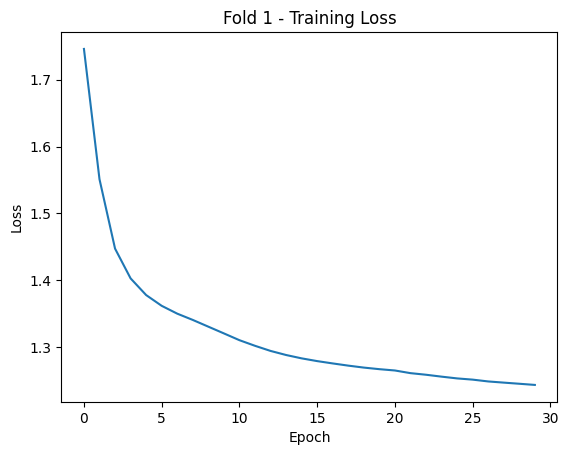

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Accuracy: 0.4691, F1: 0.2119


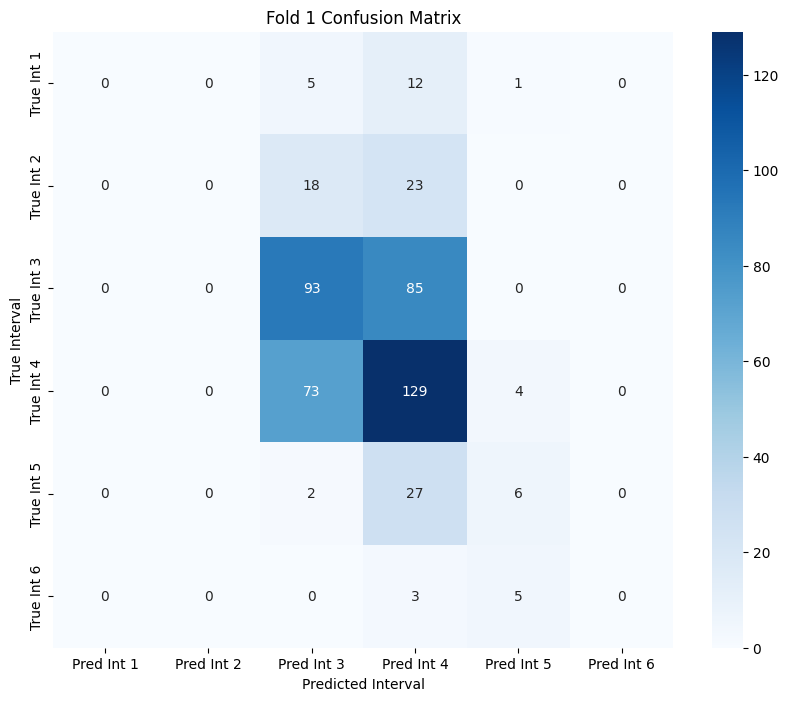

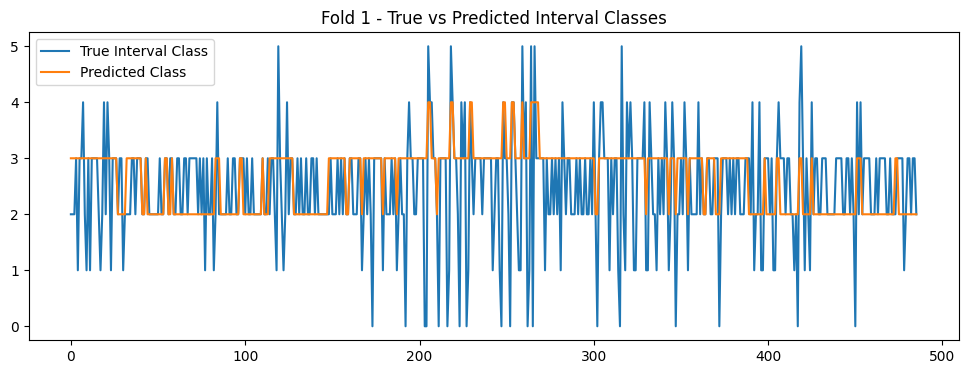

Fold 2


KeyboardInterrupt: 

In [23]:
# fine tuning on cross validation
train(3,6, 30, 0.001, 32)

In [17]:
def final_model_train(lag, num_intervals, epoch, learning_rate, batch_size, initial_money, odds=1.0):
  """
  Trains the final model using an 80/20 train-test split.
  Evaluates accuracy, F1, and applies the Kelly Criterion to measure
  how effective the trained model is at making profitable interval predictions.

  Parameters
  ----------
  lag : int
  num_intervals : int
  epoch : int
  learning_rate : float
  batch_size : int
  initial_money : float
      Starting bankroll for Kelly evaluation.
  odds : float (optional, default = 1.0)
      Betting odds (1.0 = even-money bet).
  """

  # retrieve features and labels
  X_seq, y_true, temps = feature_setup(lag, num_intervals)
  y_labels = one_hot_vector(temps, lag, y_true, num_intervals)

  # 80/20 final split
  X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
      X_seq, y_labels,
      test_size=0.2,
      shuffle=False
  )

  # build final model
  final_model = build_model(num_intervals, lag, learning_rate)

  # train on 80%
  history_final = final_model.fit(
      X_train_final, y_train_final,
      epochs=epoch,
      batch_size=batch_size,
      verbose=0
  )

  # # visualize loss curve
  # plt.figure()
  # plt.plot(history_final.history["loss"])
  # plt.title("Training Loss")
  # plt.xlabel("Epoch")
  # plt.ylabel("Loss")
  # plt.show()

  # predict test data
  y_test_pred_prob = final_model.predict(X_test_final)
  y_test_pred = np.argmax(y_test_pred_prob, axis=1)
  y_test_true = np.argmax(y_test_final, axis=1)

  # final evaluation metrics
  final_acc = accuracy_score(y_test_true, y_test_pred)
  final_f1  = f1_score(y_test_true, y_test_pred, average='macro')

  # # # confusion matrix
  # matrix_eval(y_test_true, y_test_pred, num_intervals, 0)

  # # # line graph visualization
  # line_graph(y_test_true, y_test_pred, 0)



  # -----------------------------
  #        KELLY CRITERION
  # -----------------------------
  money = float(initial_money)

  print(len(y_test_true))
  for i in range(len(y_test_true)):
      p_vec = y_test_pred_prob[i]
      predicted_class = np.argmax(p_vec)
      p = p_vec[predicted_class]

      # Kelly fraction (for even odds by default)
      f = (p * (odds + 1) - 1) / odds

      # Don’t bet if Kelly fraction negative
      if f <= 0:
          continue

      # Cap f to avoid overly aggressive bets (optional safety)
      f = min(f, 1.0)

      # Win or lose using Kelly fraction
      if predicted_class == y_test_true[i]:
          money *= (1 + f)
      else:
          money *= (1 - f)

  # print final results
  print("\n--------- FINAL MODEL RESULTS (80/20) ---------")
  print(f"Final Test Accuracy:      {final_acc:.4f}")
  print(f"Final Test F1 Score:      {final_f1:.4f}")
  print(f"Final Train Accuracy:     {history_final.history['accuracy'][-1]:.4f}")
  print(f"\nInitial Money:            ${initial_money:.2f}")
  print(f"Final Money (Kelly):      ${money:.2f}")
  print("------------------------------------------------")

  return final_model, final_acc, final_f1, money


In [25]:
model, finalAccuracy, finalF1, money = final_model_train(3,6, 30, 0.001, 32, 1000)
model.save("final_lstm_model.h5")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


584

--------- FINAL MODEL RESULTS (80/20) ---------
Final Test Accuracy:      0.4846
Final Test F1 Score:      0.2193
Final Train Accuracy:     0.4844

Initial Money:            $1000.00
Final Money (Kelly):      $2781.60
------------------------------------------------


In [19]:
moneys = []
for i in range(250):
  fm, fa, ff1, money = final_model_train(3,6, 30, 0.001, 32, 1000)
  moneys.append(money-1000)
  print(i)


moneys = np.array(moneys)

mean_val = np.mean(moneys)
median_val = np.median(moneys)

plt.figure(figsize=(8, 5))
plt.hist(moneys, bins=10, edgecolor='black', alpha=0.7)

# Draw mean + median lines
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f"Mean: {mean_val:.2f}")
plt.axvline(median_val, color='green', linestyle='dashed', linewidth=2, label=f"Median: {median_val:.2f}")

plt.title("Distribution of Final Money")
plt.xlabel("Final Money")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis='y', alpha=0.4)

plt.show()



19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
584

--------- FINAL MODEL RESULTS (80/20) ---------
Final Test Accuracy:      0.4384
Final Test F1 Score:      0.2015
Final Train Accuracy:     0.4827

Initial Money:            $1000.00
Final Money (Kelly):      $2559.84
------------------------------------------------
0
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
584

--------- FINAL MODEL RESULTS (80/20) ---------
Final Test Accuracy:      0.4692
Final Test F1 Score:      0.2085
Final Train Accuracy:     0.4822

Initial Money:            $1000.00
Final Money (Kelly):      $8468.41
------------------------------------------------
1
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
584

--------- FINAL MODEL RESULTS (80/20) ---------
Final Test Accuracy:      0.5034
Final Test F1 Score:      0.2044
Final Train Accuracy:     0.4707

Initial Money:            $1000.00
Final Money (Kelly):      $33.46
------------------------------------------------
2
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
584

--------- FINAL

KeyboardInterrupt: 